In [8]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# 将当前工作目录添加到 Python 路径
# 获取当前工作目录
current_working_dir = os.getcwd()

# 将根目录添加到 sys.path
sys.path.append(os.path.abspath(os.path.join(current_working_dir, '../..')))

from function import metrics_to_dataframe, plot_actual_vs_predicted

In [9]:
# 读取数据
data = pd.read_csv('../dataset_removed_outliers_z.csv')

# 对指定列进行独热编码
columns_to_encode = ['CM_type', 'CM_morph', 'MS2_morph', 'CP_morph', 'Cation', 'Anion']
data_encoded = pd.get_dummies(data, columns=columns_to_encode)

In [10]:
# X = data_encoded.drop(['Cs'], axis=1)
# y = data_encoded['Cs']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=21
# )

data_encoded['target_class'] = pd.qcut(data_encoded['Cs'], q=10, labels=False)
X = data_encoded.drop(['Cs', 'target_class'], axis=1)
y = data_encoded['Cs']
stratify_column = data_encoded['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)

In [11]:
# optuna 自动搜索超参数
import optuna
def objective(trial):
    param = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2025-03-07 10:46:44,815] A new study created in memory with name: no-name-b8313247-a0d0-4bcd-b528-c6ec1285e2ac
[I 2025-03-07 10:46:44,992] Trial 0 finished with value: 91.0092645866683 and parameters: {'learning_rate': 0.17637337033997988, 'subsample': 0.5794551794635854, 'gamma': 0.8335214143180536, 'max_depth': 6, 'min_child_weight': 4, 'reg_alpha': 0.9117318616661161, 'colsample_bytree': 0.7131035544499809, 'colsample_bylevel': 0.6381738478014205, 'colsample_bynode': 0.5280806397444695}. Best is trial 0 with value: 91.0092645866683.
[I 2025-03-07 10:46:45,494] Trial 1 finished with value: 104.55925412131455 and parameters: {'learning_rate': 0.11283258935915441, 'subsample': 0.8490586629424722, 'gamma': 0.1628317190239712, 'max_depth': 18, 'min_child_weight': 1, 'reg_alpha': 0.05084492908449478, 'colsample_bytree': 0.8405302634644642, 'colsample_bylevel': 0.8539622191017817, 'colsample_bynode': 0.8329781852408111}. Best is trial 0 with value: 91.0092645866683.
[I 2025-03-07 10:46:

Best trial:
  Value: 72.97536093290206
  Params: 
    learning_rate: 0.1685107529495761
    subsample: 0.635560398528411
    gamma: 0.22940328433255047
    max_depth: 7
    min_child_weight: 4
    reg_alpha: 0.07390504728749239
    colsample_bytree: 0.616955657046956
    colsample_bylevel: 0.8853173596898991
    colsample_bynode: 0.7604047110047993


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


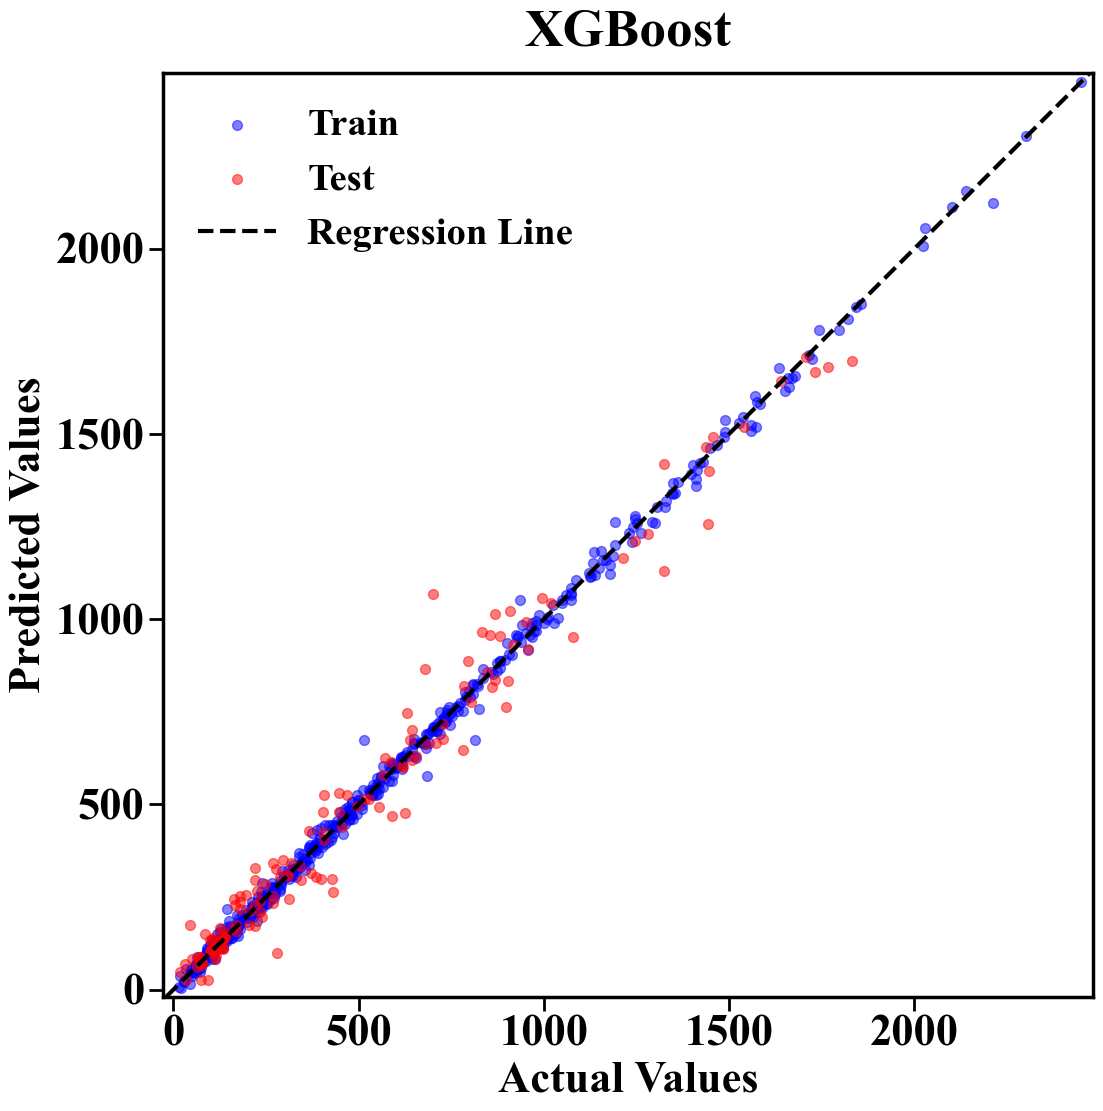

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,XGBoost,0.998,12.96,4.81,20.32,0.973,50.54,18.39,72.98


In [12]:
# 使用最佳参数训练模型
xgb_params = {
    'n_estimators': 300,
    'learning_rate': trial.params['learning_rate'],
    'subsample': trial.params['subsample'],
    'gamma': trial.params['gamma'],
    'max_depth': trial.params['max_depth'],
    'min_child_weight': trial.params['min_child_weight'],
    'reg_alpha': trial.params['reg_alpha'],
    'colsample_bytree': trial.params['colsample_bytree'],
    'colsample_bylevel': trial.params['colsample_bylevel'],
    'colsample_bynode': trial.params['colsample_bynode'],    
}
model = XGBRegressor(**xgb_params)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost', figpath='xgb_actual_vs_predicted.png')
xgb_metrics = metrics_to_dataframe(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost')
xgb_metrics

In [13]:
data_1 = pd.read_csv('../dataset_removed_outliers_iqr.csv')
data_encoded_1 = pd.get_dummies(data_1, columns=columns_to_encode)

data_encoded_1['target_class'] = pd.qcut(data_encoded_1['Cs'], q=10, labels=False)
X_1 = data_encoded_1.drop(['Cs', 'target_class'], axis=1)
y_1 = data_encoded_1['Cs']
stratify_column_1 = data_encoded_1['target_class']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=21, stratify=stratify_column_1)



In [14]:
def objective(trial):
    param = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
    }

    model = XGBRegressor(**param)
    model.fit(X_train_1, y_train_1)
    y_pred = model.predict(X_test_1)
    rmse = np.sqrt(np.mean((y_test_1 - y_pred) ** 2))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))



[I 2025-03-07 13:00:23,597] A new study created in memory with name: no-name-b21727d4-de7d-4734-a9c2-ed0fd930f4de
[I 2025-03-07 13:00:23,788] Trial 0 finished with value: 74.93223402437344 and parameters: {'learning_rate': 0.0889665402031025, 'subsample': 0.4338215034399079, 'gamma': 0.2941123063628398, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0.6487454880914028, 'colsample_bytree': 0.7501614967378069, 'colsample_bylevel': 0.9375280143691109, 'colsample_bynode': 0.6610549942360822}. Best is trial 0 with value: 74.93223402437344.
[I 2025-03-07 13:00:23,941] Trial 1 finished with value: 82.0711168221439 and parameters: {'learning_rate': 0.2772113377102667, 'subsample': 0.7901737167909543, 'gamma': 0.9044497000153339, 'max_depth': 5, 'min_child_weight': 8, 'reg_alpha': 0.8302992019878974, 'colsample_bytree': 0.8724723135226835, 'colsample_bylevel': 0.9615388885664803, 'colsample_bynode': 0.6962983482028764}. Best is trial 0 with value: 74.93223402437344.
[I 2025-03-07 13:00:24,

Best trial:
  Value: 62.733007536434684
  Params: 
    learning_rate: 0.17278252212643613
    subsample: 0.5076419899108141
    gamma: 0.14655719245254217
    max_depth: 16
    min_child_weight: 4
    reg_alpha: 0.8388057914056619
    colsample_bytree: 0.9323203689198103
    colsample_bylevel: 0.8112341882493177
    colsample_bynode: 0.8249927097992265


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


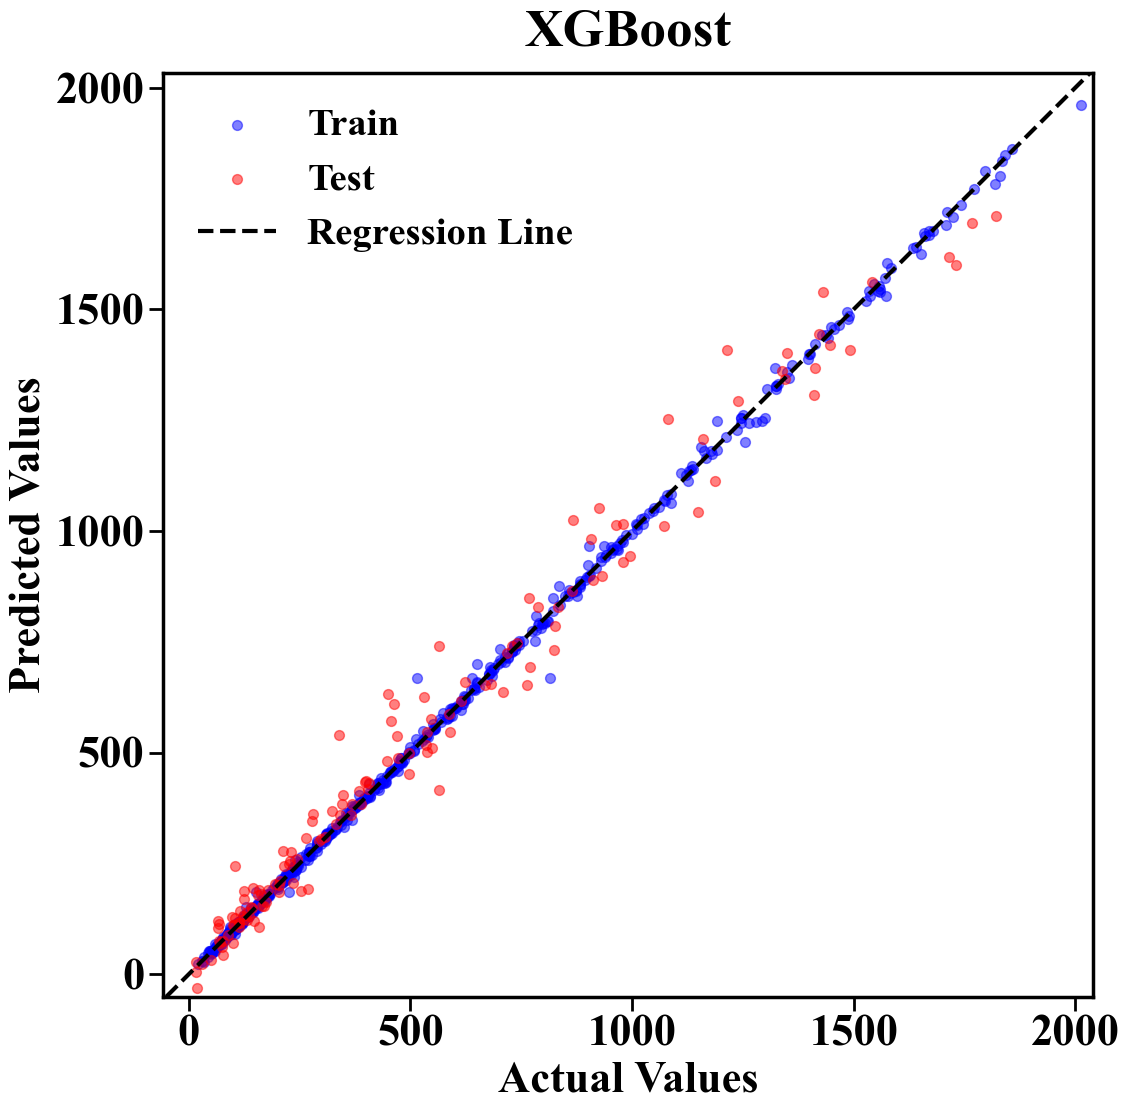

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,XGBoost,0.999,6.63,1.97,13.76,0.981,44.0,15.82,62.73


In [15]:
xgb_params_1 = {
    'n_estimators': 300,
    'learning_rate': trial.params['learning_rate'],
    'subsample': trial.params['subsample'],
    'gamma': trial.params['gamma'],
    'max_depth': trial.params['max_depth'],
    'min_child_weight': trial.params['min_child_weight'],
    'reg_alpha': trial.params['reg_alpha'],
    'colsample_bytree': trial.params['colsample_bytree'],
    'colsample_bylevel': trial.params['colsample_bylevel'],
    'colsample_bynode': trial.params['colsample_bynode'],    
}

model_1 = XGBRegressor(**xgb_params_1)
model_1.fit(X_train_1, y_train_1)

y_train_pred_1 = model_1.predict(X_train_1)
y_test_pred_1 = model_1.predict(X_test_1)

plot_actual_vs_predicted(y_train_1, y_train_pred_1, y_test_1, y_test_pred_1, 'XGBoost', figpath='xgb_actual_vs_predicted_1.png')
xgb_metrics_1 = metrics_to_dataframe(y_train_1, y_train_pred_1, y_test_1, y_test_pred_1, 'XGBoost')
xgb_metrics_1